RNN - Erro dos pesos computados e usado somente durante a iteração

In [11]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import operator as op
import ipynbname
import math
import time
from Functions.Utils import *
from Functions.RLS import *
from Functions.RTLO import *
from Functions.Graphs import *
from Functions.TEDA import *
from Functions.TedaGraphs import *
import optuna
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_pareto_front
from optuna.importance import get_param_importances
from optuna.samplers import RandomSampler
import os
import re
import sys
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib as mpl
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random
FileName = ipynbname.name()
K=0

brngs1 = ['Bearing1_1.csv','Bearing2_2.csv','Bearing1_2.csv','Bearing1_3.csv','Bearing2_5.csv']
Mp = [1.42, 14, 5, False]
Mp2 =[5, 25, 0.01, 1e-06, 1e-10, 1e-07, 22]

In [2]:
dir_rs = r'C:\Artigo_J3C_V2\VMD10\RS6_def\S2_A1_Q10_W10_RS_raw\RS1'
dir_hi = r'C:\Artigo_J3C_V2\VMD10\HI'

0.17797083044716383


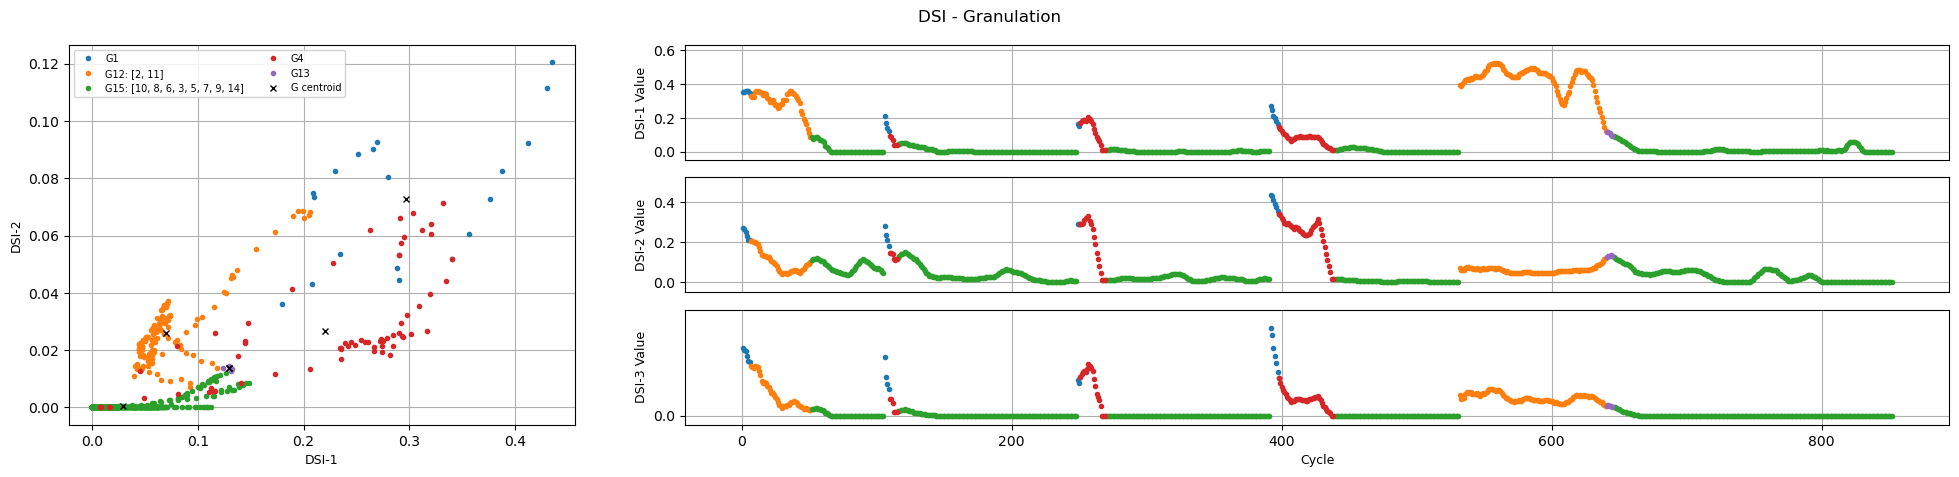

In [3]:
#Mp = [1.54, 3, 5, False]
m, nRS, st, drop= [1.42, 14, 5, False]
brngs = brngs1
for i,brng in enumerate(brngs[:5]):
    df_RS = (pd.read_csv(os.path.join(dir_rs,brng)).abs()).iloc[:,:-1]
    df_HI = (pd.read_csv(os.path.join(dir_hi,brng)).abs()).iloc[:,:1]
    if drop: df_RS = df_RS.drop(columns='Y')
    xS = process_RS(df_RS, nRS)[st:]

    if i==0: teda=AutoCloud(m=m, nS=len(xS[0]), nI=1, nR=1, nO=1, N1=1, N2=1, N3=1,
                            tau=1, decay=1, eol=0.3, fator=1) 
    elif i>0: teda.reset_rul()
    teda.add_rulR2(n=-(st+nRS)+len(df_RS))

    for j,_ in enumerate(xS):
        x = xS[j]
        if i <= 1: teda.run(X=x,MergeGrnls=True,MergeOffGrnls=True,FitOffGrnls=True,OfflineRun=True)
        else: teda.run(x,MergeGrnls=True,MergeOffGrnls=True,FitOffGrnls=True, OfflineRun=True)
    
    if i==1:
        teda.OffineGrnls = [cloud for cloud in teda.c]
        #plot_DSI2(teda,ftrs=len(df_RS.columns),title='DSI - Granulation',ncol=2)
        #plot_DSI(teda,h=5,w=15,ftrs=None,start=-len(df_RS.columns),mergeID=True,title='DSI - Granulation',ncol=2)
    for cloud in teda.c[:]:
        cloud.calc_Dmax(teda.xR,teda.xF)
        cloud.calc_v(k=teda.k)

vgrnls,ngrnls = np.array([]),np.array([])

for cloud in teda.c[:]:
    cloud.calc_Dmax(teda.xR,teda.xF)
    cloud.calc_v(k=teda.k)
    vgrnls = np.append(vgrnls,cloud.v*cloud.n)
    ngrnls = np.append(ngrnls,cloud.n)
print(np.sum(vgrnls)/np.sum(ngrnls))
    #for cloud in teda.c:
    #    print(cloud.ID,len(cloud.t),len(np.array(cloud.x).T[-1]))

#plot_DSI(teda,h=5,w=15,ftrs=None,start=-len(df_RS.columns),mergeID=True,title='DSI - Granulation',ncol=2)
plot_DSI2(teda,ftrs=3,title='DSI - Granulation',ncol=2,w=20,h=5)
#plot_DSI_3D(teda,h=5,w=15,ftrs=None,start=-3,mergeID=False,title='DSI - Granulation',ncol=2)
#plot_DSI_plotly(teda)

0.48196541788412506 6


0.585318463038169 None


0.8021624015522745 None


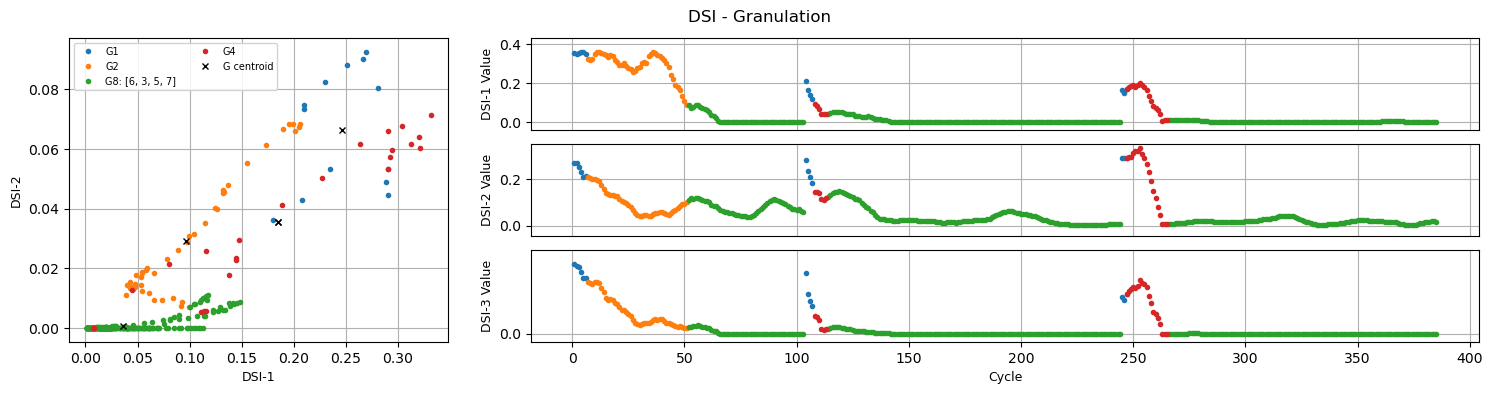

In [12]:
m, nRS, st, drop= Mp
nHI, nR, N1, N2, N3,D, tau = Mp2
init = (st+nRS)
len_=0
brngs = brngs1
for i,brng in enumerate(brngs[:3]):
    mapeInit,check = None, False
    df_RS = (pd.read_csv(os.path.join(dir_rs,brng)).abs()).iloc[:,:-1]
    df_HI = (pd.read_csv(os.path.join(dir_hi,brng)).abs()).iloc[:,-1:]
    if drop: df_RS = df_RS.drop(columns='Y')
    RS = process_RS(df_RS,nRS)
    HI = process_HI(df_HI,nHI=nHI,init=init)
    xS,yS,zS = RS[st:-2], HI[:-1], HI[1:]
    if i==0: 
        teda=AutoCloud(m=m, nS=len(xS[0]), nI=len(yS[0]), nR=nR, nO=len(yS[0]), 
                            N1=N1, N2=N2, N3=N3, tau=tau, decay=D,
                            eol=0.2, fator=1,st=st+nRS-1) 
    elif i>0: teda.reset_rul()
    teda.wta = True
    teda.add_rulR2(n=-(st+nRS)+len(df_RS))
    for j,_ in enumerate(xS):
        x= xS[j]
        y,z = yS[j],zS[j]

        if i <= 1: teda.run(X=x,MergeGrnls=True,MergeOffGrnls=True,FitOffGrnls=True,OfflineRun=True)
        else: teda.run(x,MergeGrnls=True,MergeOffGrnls=True,FitOffGrnls=True, OfflineRun=True)
        
        teda.adapt(y,z)
        teda.RUL_single(y)

        if i ==0:
            if np.any(1 != teda.cloud_activation2[-1]) and not check:
                mapeInit=j
                check = True
                DamagedGrnl = (teda.cloud_activation2[-1])
        elif i>0 and not check:
            if DamagedGrnl in teda.cloud_activation3[-1]:
                mapeInit = j + 0
                check = True

    mape2 = teda.TimelyWeightedMAPE(rult=teda.cycleP,rulR=teda.rulR2,start=mapeInit)
    check = False
    print(mape2,mapeInit)
    plot_2series(x1=teda.cycleP,x2=teda.cycleP,y1=teda.rulR2,y2=teda.rulP, title=brng,s1='True',s2='Pred')

plot_DSI2(teda,ftrs=3,title='DSI - Granulation',ncol=2)
